# GEOL20E HW6: Nutrient Modeling
## Introduction
This project is adapted from a "Superproblem" published in _Tracers in the Sea_ by Broecker and Peng (1982). Our goal is to understand spatial patterns in marine chemistry by modeling physical and biological nutrient cycles.

Our setup is depicted below: four big tanks as a rather simplified analog of the global ocean. The left column is the combined Indian & Pacific; the right is the Atlantic. Each basin has a small surface tank and a larger deep tank. The number on each tank is its volume in liters. Tanks will always be listed in order from A to D.

Just like in the ocean, water circulates. Black arrows between tanks represent pumps, labeled with volumetric fluxes in liters per hour.

Finally, we model biologically-driven nutrient flux, which operates differently than the physical circulation described above. These are the green arrows, and we will have to be creative in how we define them. But before we get to the biological component, let's start modeling physical circulation.

<img src="schematic.pdf" width=600 />

To start, we import some libraries. While we're at it, let's adjust some default plot settings. Matplotlib has lots of options; explore the online documentation for more ideas. Click to highlight the cell below and press Shift-Return to run.

In [86]:
import numpy as np # mathematics, computing, arrays
from scipy.integrate import odeint # ordinary differential equations
import matplotlib.pyplot as plt # plots

plt.rc('figure', dpi = 300, figsize = [6, 3]) # plot size and resolution
plt.rc('legend', loc = "upper right") # legend position
abcd = ('A','B','C','D') # legend labels

plt.rc('axes', grid = True)
plt.rc('axes.grid', axis = 'y') # horizontal lines
plt.rc('grid', linestyle = ':') # those lines are dotted

Next, let's define the physical parameters as outlined above: volumes & volumetric fluxes. Volumes are self explanatory, but it may take some thought to understand how the fluxes below match those above. Some hints: pay particular attention to the main diagonal (top left to bottom right). Also, think about how you might want to organize these fluxes if the real question you're after is how they change the nutrient content of each reservoir.

If you change these values, re-run the cell (Shift-Return) & any other cells that reference these values. Volumes can be redefined freely, but make sure to keep fluxes balanced so reservoir volumes don't change over time. And remember, these numbers are meant to capture certain aspects of the real ocean: the Indo-Pacific is larger than the Atlantic, most deepwater formation occurs in the Atlantic, the Pacific is dominated by diffuse upwelling, etc.

In [87]:
# reservoir volumes
v = np.array([600, 300, 3000, 6000]) # L

# volumetric fluxes
Q = np.array([[-8,  2,  0,  6],
              [8, -12,  4,  0],
              [0,  10, -12, 2],
              [0,  0,   8, -8]]) # L/hr

We start by modeling phosphate, a dissolved species which is transported ("advected") by physical circulation. Later, we will see its biological role as well. We need to define initial concentrations in each reservoir and a time interval over which we want to predict the future:

In [110]:
# initial [PO4]
phosphate_0 = np.array([2, 2, 2, 2]) # umol/L

# time range: first, last, interval
t = np.arange(0, 5000, 1) # hr

Now we are ready to design a model. Intuitively, we might expect this system to be rather boring, especially since every reservoir starts with the same concentration. But let's take this opportunity to learn the basics of modeling using a system of differential equations.

## Part I. Modeling Physical Circulation

What's our goal here? The idea is to predict the future using information we know to be true at any particular moment. The strategy is to design a system of _differential equations_ in which we express rates (like changes in concentration) in terms of states ( concentrations, fluxes, etc.) Specifically, let's list all four concentrations in a vector $\mathbf{c}$. We should really say $\mathbf{c}(t)$ is a function of time; we want a function where we can plug in some future time and we have a list of all the concentrations. But this explicit function is not possible to determine simply by examining the model. What we _can_ determine from the model is an expression for $d\mathbf{c}/dt$, which is the rate at which $\mathbf{c}$ changes over time. Then we let python do some calculus to numerically approximate the function $\mathbf{c}(t)$.

Let's start by considering nutrient _amounts_ rather than concentrations. An amount is a concentration times a volume, so the left side of our equation will be $\mathbf{v}\mathbf{c}'$ (element-wise multiplication with the vector of volumes to end up with another vector with four amounts).

On the right side, we need an expression rate at which each nutrient amount changes over time. The answer is all the influxes minus all the outfluxes. The matrix $Q$ is organized such that each reservoir gets a "row" containing all the fluxes relevant to that reservoir. Negative entries on the diagonal represent combined outfluxes; off-diagonal entries are influxes broken down by source. Source is important because the concentration in any flux matches the concentration in the source reservoir.

If you've seen a problem like this before, you may recognize that we need a matrix-vector product. The key idea here is that the _rate of change_ for every component is determined by the _state_ of every component. So the right side of our equation is $Q\mathbf{c}$. Putting both sides together:

$$\mathbf{v}\mathbf{c}'=Q\mathbf{c}$$

Since that product on the left is element-wise, we can divide both sides of the equation element-wise by $\mathbf{v}$ to give our final expression:

$$\mathbf{c}'=Q\mathbf{c}/\mathbf{v}$$

Here's how we put this system of equations into python:

In [95]:
# define system of differential equations
def system_abiotic(c, t):
    return Q @ c / v

Now we need to computer to "solve" the system of equations. Remember, we are looking for an explicit function of time $\mathbf{c}(t)$. The way the computer does this is by starting at the initial condition, solving for $\mathbf{c}'$ using the function we defined, and then taking a tiny step in that direction. And then it repeats, until those tiny steps add up to the entire interval we're looking for. This gives a very good approximation of the the true solution--it is an approximation because it divides continuous time into very small steps, but that doesn't affect the final result very much.

In [96]:
# solve system_abiotic with c = phosphate_0 and t = t (arange defined above)
solution_abiotic = odeint(system_abiotic, phosphate_0, t)

If everything has worked properly, nothing noticable will happen. The computer has solved for $\mathbf{c}(t)$ so let's plot it. 

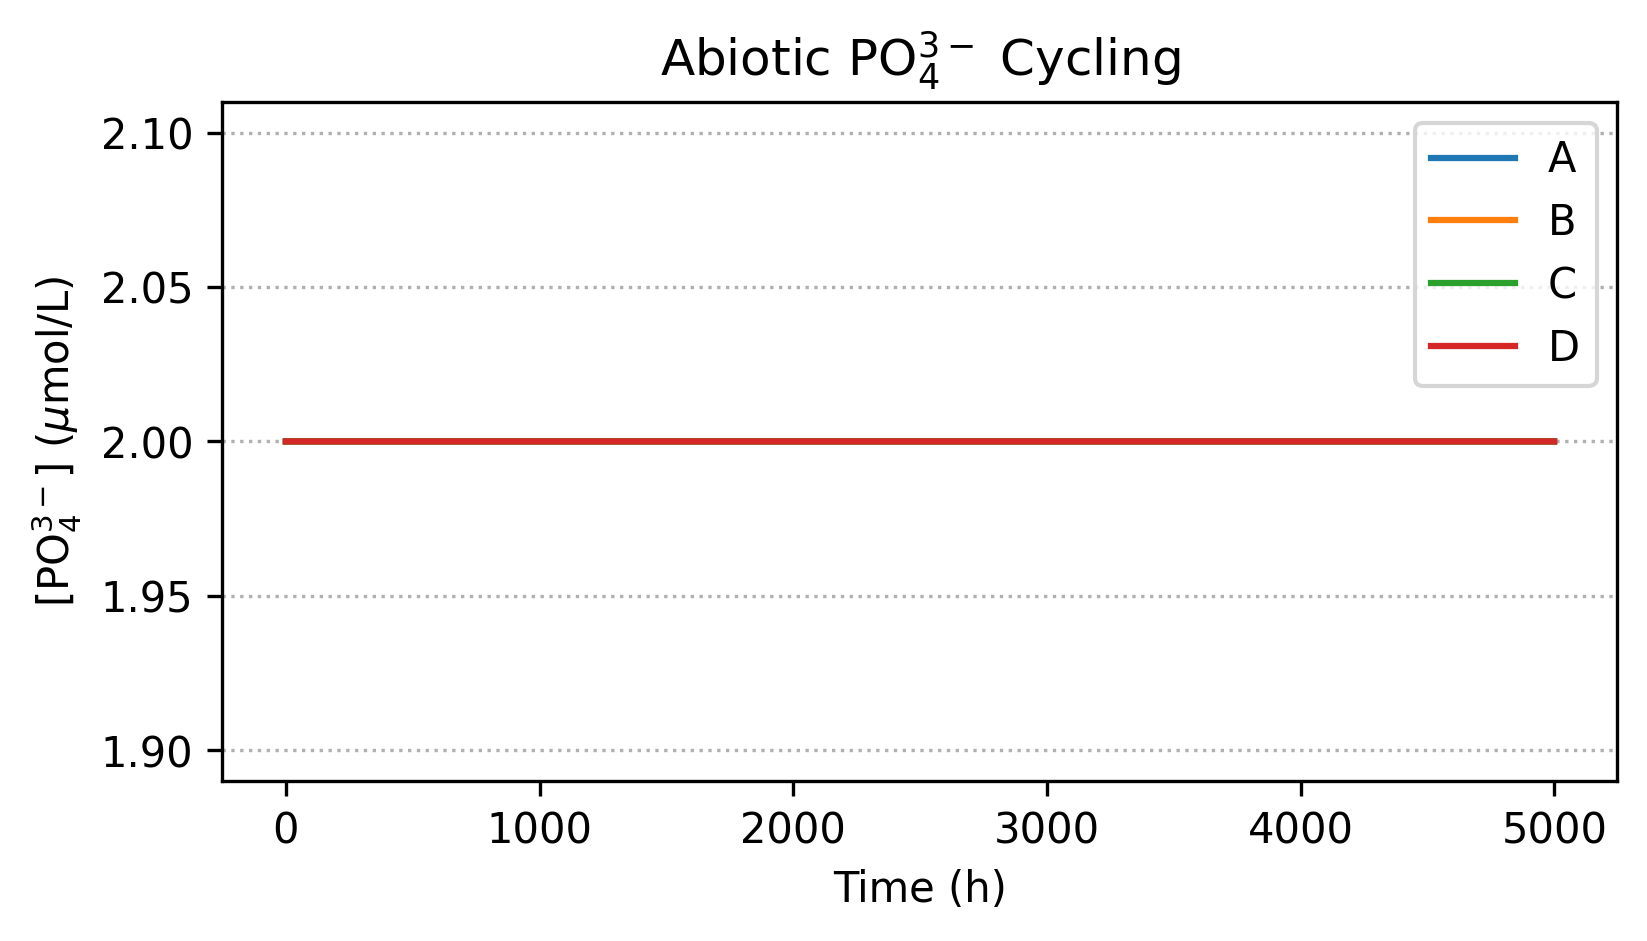

In [97]:
plt.plot(t, solution_abiotic, label=abcd)
plt.xlabel('Time (h)')
plt.ylabel('[PO$_4^{3-}$] ($\mu$mol/L)')
plt.title('Abiotic PO$_4^{3-}$ Cycling')
plt.legend()

plt.savefig("abiotic.pdf")
plt.show()

#print(solution_abiotic[-1])

Boring! The system is at steady-state (s.s.) from the beginning. But it doesn't have to be! Go back and adjust the initial concentrations of each reservoir. Predict the behavior of the system. Re-run each block of code and compare the behavior with the first case.

## Part II: The Biological Pump

Next, we incorporate biological nutrient cycling. Let's review what's going on here, why it happens in the ocean, and how to incorporate the process into our model.

In addition to carbon dioxide, light, and water, photosynthetic primary producers in the surface ocean need _nutrients_ such as phosphate, nitrate, and iron. In this model we consider only phosphate. When phosphate is consumed and incorporated into organism tissue, its concentration decreases in the immediate vicinity (the surface reservoir). When algae die, their bodies sink to the deep ocean where they are consumed by heterotrophs, "remineralizing" the nutrients and _increasing_ concentration in the corresponding deep reservoir. Without belaboring the biochemical details, we can thus model the net effect of biological nutrient cycling as a transport from the surface to the deep.

Unlike advective physical circulation, which we have seen tends to homogenize reservoirs, this process is _independent of physical water transport_ and can operate _against a concentration gradient,_ so we use the term "pump." Let's add this to the model:

$$\mathbf{c}'=\left(Q \mathbf{c} + \mathbf{b}\right)/\mathbf{v}$$

Notice that $\mathbf{b}$ is an amount flux on its own, not a product of a volume flux and concentration like we saw before. The tricky part is to actually define it. To start with, we know it represents two distinct vertical pathways, each of which should be included as one positive entry balanced by one negative entry. And keep in mind, we want to account for real trends observed in the ocean. Namely, most of the ocean surface is almost completely devoid of nutrients! Pay attention to how this vector term is defined in the following implementations:

### Method 1: Concentration

In this implementation, we assume the biological pump in an ocean basin is proportional to the concentration of nutrients at the surface of that basin. You should think carefully about whether this is a reasonable assuption. In any case, we introduce a proportionality constant $\beta$, which we will say is the same in both reservoirs. Again, if you find this an unrealistic assumption, feel free to adjust the model!

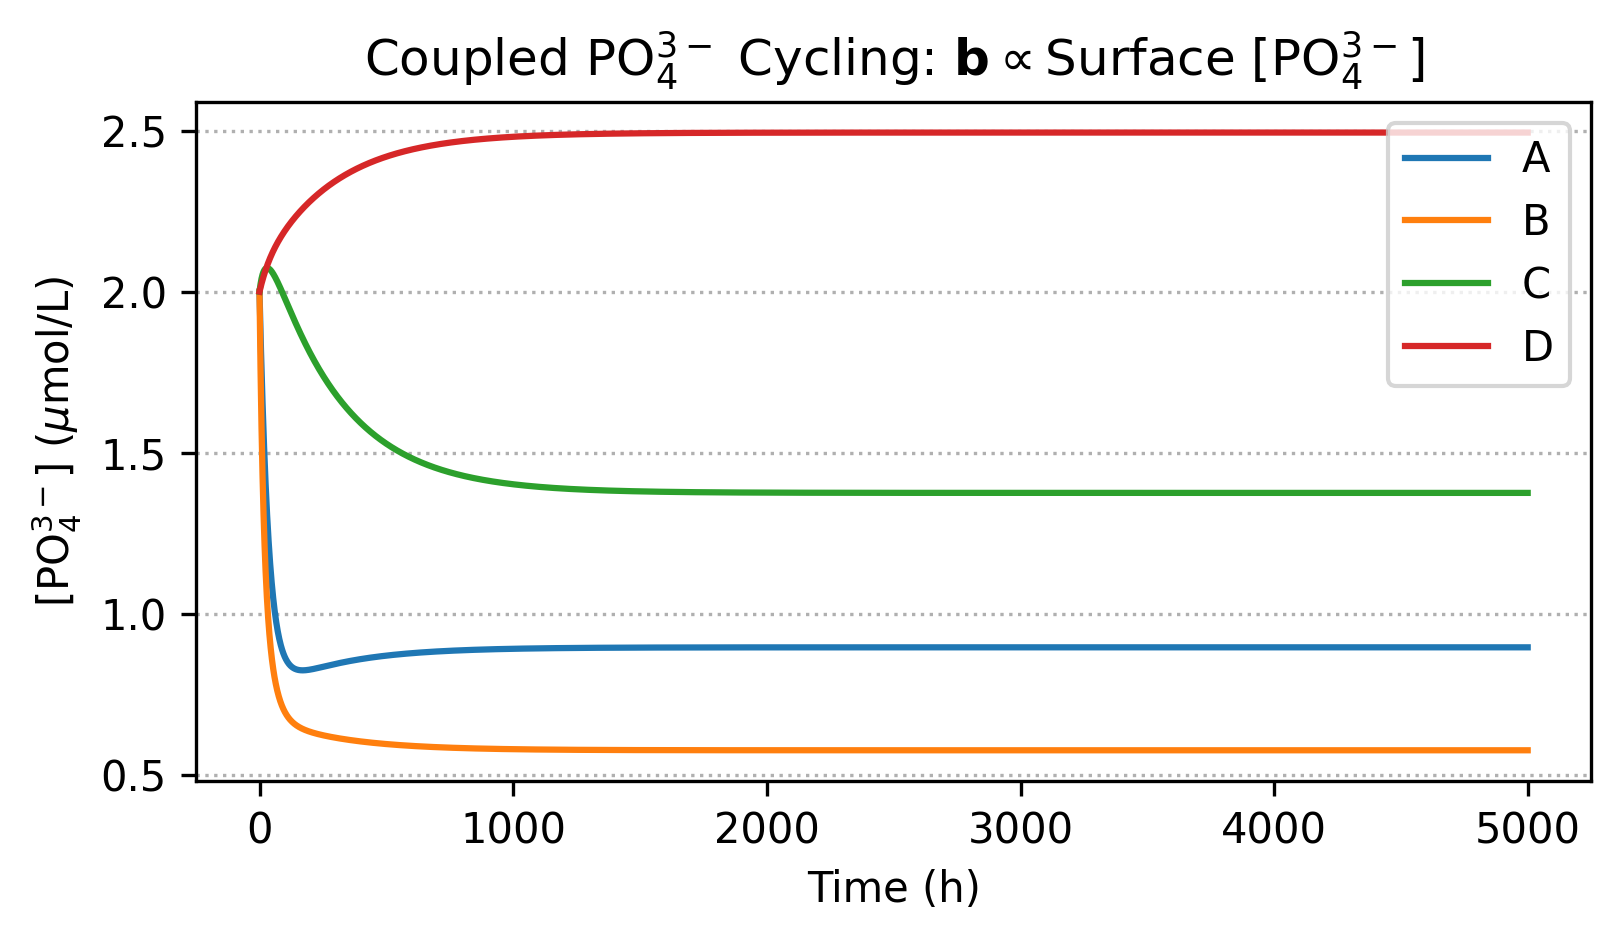

In [98]:
beta_c = 10 # (L/hr)

def system_c(c, t):
    b = beta_c*np.array([-c[0], -c[1], c[1], c[0]]) # c[n] is the nth entry of c, starting at 0
    return (Q @ c + b) / v

solution_c = odeint(system_c, phosphate_0, t)

plt.plot(t, solution_c, label=abcd)
plt.xlabel('Time (h)')
plt.ylabel('[PO$_4^{3-}$] ($\mu$mol/L)')
plt.title('Coupled PO$_4^{3-}$ Cycling: $\mathbf{b} \propto$Surface [PO$_4^{3-}$]')
plt.legend()

plt.savefig("conc.pdf")
plt.show()

#print(solution_c[-1])

What beta values are necessary for the equilibrium concentrations of the surface reservoirs to reach essentially zero, say, less that 0.01 umol/L? Do the two deep reservoirs end up with roughly the same concentration? What about the surface reservoirs?

### Method 2: Influx

Another approach is to assume that the biological pump is proportional to the total nutrient flux into the corresponding surface reservoir. Let's see what this model predicts:

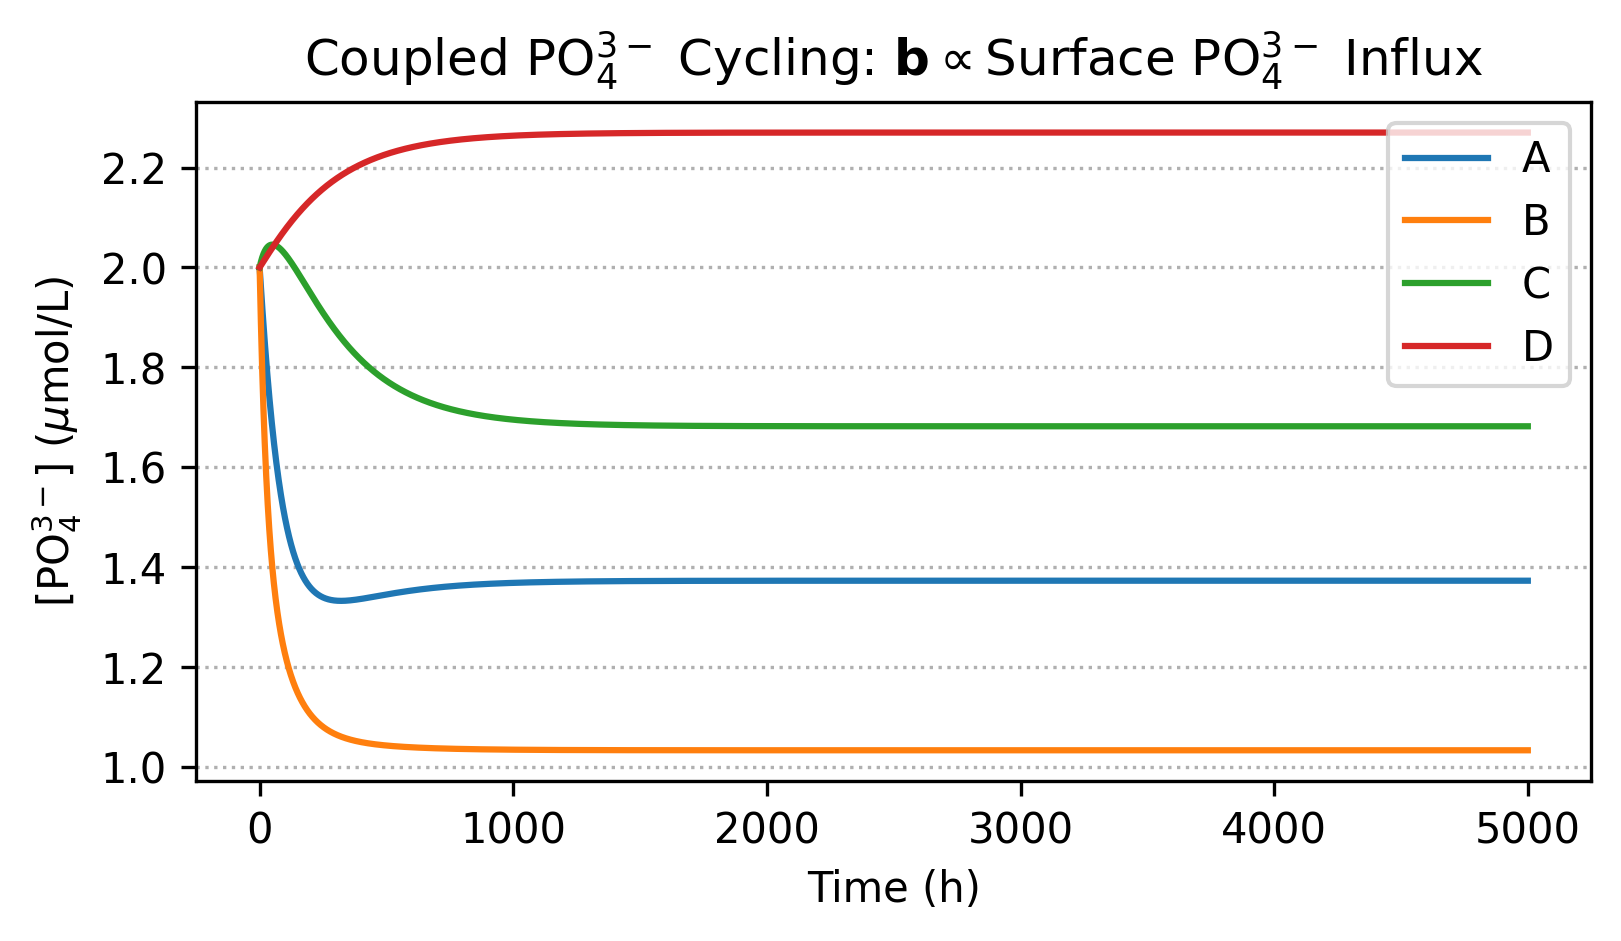

In [99]:
beta_q = .3

Q_hollow = np.copy(Q) # matrix of influxes only
np.fill_diagonal(Q_hollow, 0) # hollow matrix = zeros on diagonal

def system_q(c, t):
    A = Q_hollow[0] @ c
    B = Q_hollow[1] @ c
    b = beta_q*np.array([-A, -B, B, A])
    return (Q @ c + b) / v

solution_q = odeint(system_q, phosphate_0, t)

plt.plot(t, solution_q, label=abcd)
plt.xlabel('Time (h)')
plt.ylabel('[PO$_4^{3-}$] ($\mu$mol/L)')
plt.title('Coupled PO$_4^{3-}$ Cycling: $\mathbf{b} \propto$Surface PO$_4^{3-}$ Influx')
plt.legend()

plt.savefig("flux.pdf")
plt.show()

#print(solution_q[-1])

Once again, what $\beta$ values are necessary to reach near-zero surface concentrations? What similarities and/or differences do you notice between the two models? How do you physically interpretat each of the two $\beta$ parameters we defined? Hint: think about units!

## Part III: Oxygen

Finally, we build on the most recent iteration of the coupled model to trace oxygen, whose cycling is linked stoichiometrically to that of nutrients such as phosphate. Unlike phosphate, oxygen exchanges with the atmosphere at the surface. Make sure you understand how these factors are incorporated, explore the model, and evaluate the results. The equations in the system involving oxygen are:

$$\mathbf{c}'=\left(Q\mathbf{c} + \mathbf{b}\right)/\mathbf{v} + \mathbf{r}.$$

These are added to the previous system for a total of eight equations. The two sets of four are combined using "np.append." The first four are extracted using "c[:4];" the last four using "c[4:]."

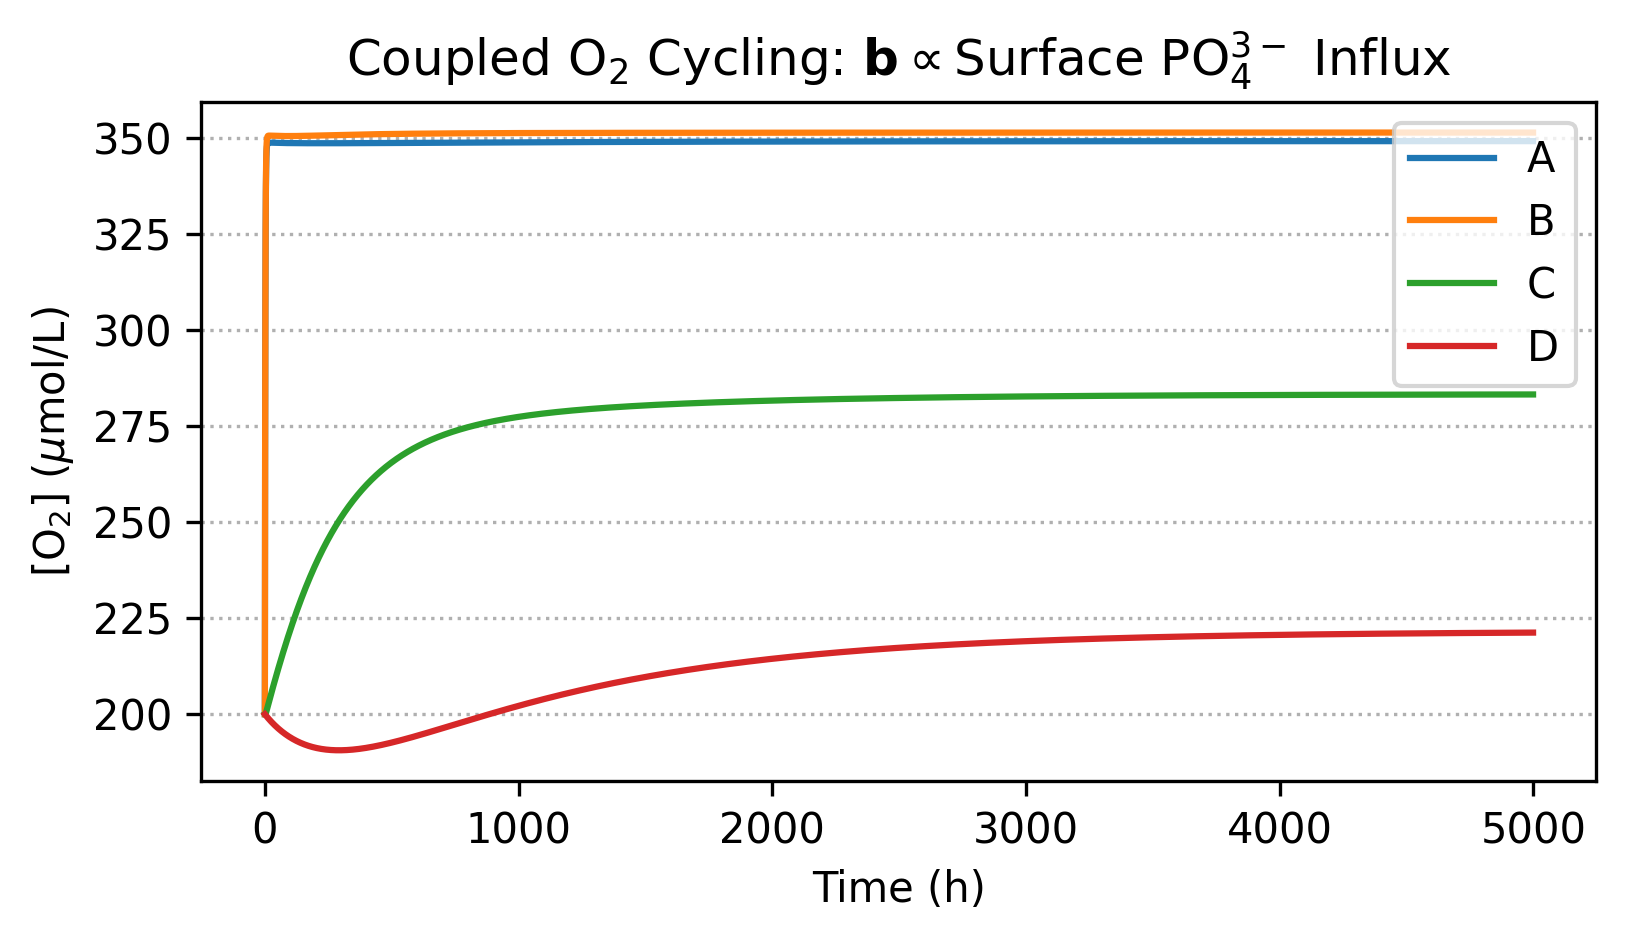

In [112]:
# Initial [O2] (umol/L)
oxygen_0 = np.array([200, 200, 200, 200])
c_0 = np.append(phosphate_0, oxygen_0) # keep track of all eight concentrations 

R = -105 # Redfield ratio: O2:PO4 in photosynthesis
c_eq = 350 # surface [O2] at atmospheric equilibrium (umol/L)
k_eq = 0.6 # atmospheric equilibration rate constant (/hr)

def system_oxy_q(c, t):
    A = Q_hollow[0] @ c[:4]
    B = Q_hollow[1] @ c[:4]
    b = beta_q*np.array([-A, -B, B, A])
    r = k_eq*np.array([c_eq-c[4], c_eq-c[5], 0, 0])
    return np.append((Q @ c[:4] + b) / v,
                     (Q @ c[4:] + R * b) / v + r)

solution_oxy_q = odeint(system_oxy_q, c_0, t)

plt.plot(t, solution_oxy_q.T[4:].T, label=abcd) # only plot oxygen
plt.xlabel('Time (h)')
plt.ylabel('[O$_2$] ($\mu$mol/L)')
plt.title('Coupled O$_2$ Cycling: $\mathbf{b} \propto$Surface PO$_4^{3-}$ Influx')
plt.legend()

plt.savefig("oxy.pdf")
plt.show()

#print(solution_oxy_q[-1,6:]) # show deepwater oxygen concentrations (surface defined)

## Part IV: Summary

To conclude the activity, write a brief summary essay answering the following questions:

For the abiotic physical circulation model, what factors influence the system's initial behavior and long term steady-state conditions? Be sure to interpret any differences you notice in the behavior of the four reservoirs.

Which definition of the biological flux do you think is a more accurate reflection of real ocean nutrient cycling? Under what spatial or temporal circumstances (if any) would you use these definitions?

Do some cursory research into broad nutrient and oxygen trends in the Atlantic and Pacific oceans. Can this model provide any insight into why these trends might occur?

Include at least three plots in your write-up with documentation of the relevant model assumptions, equations, parameters, etc.

BONUS: Explore and evaluate the following model, which duplicates the problem as it was originally posed by Broecker and Peng (1982). What new behaviors do you notice? What does this model capture about the real ocean? Hint: you will need to adjust the time interval...

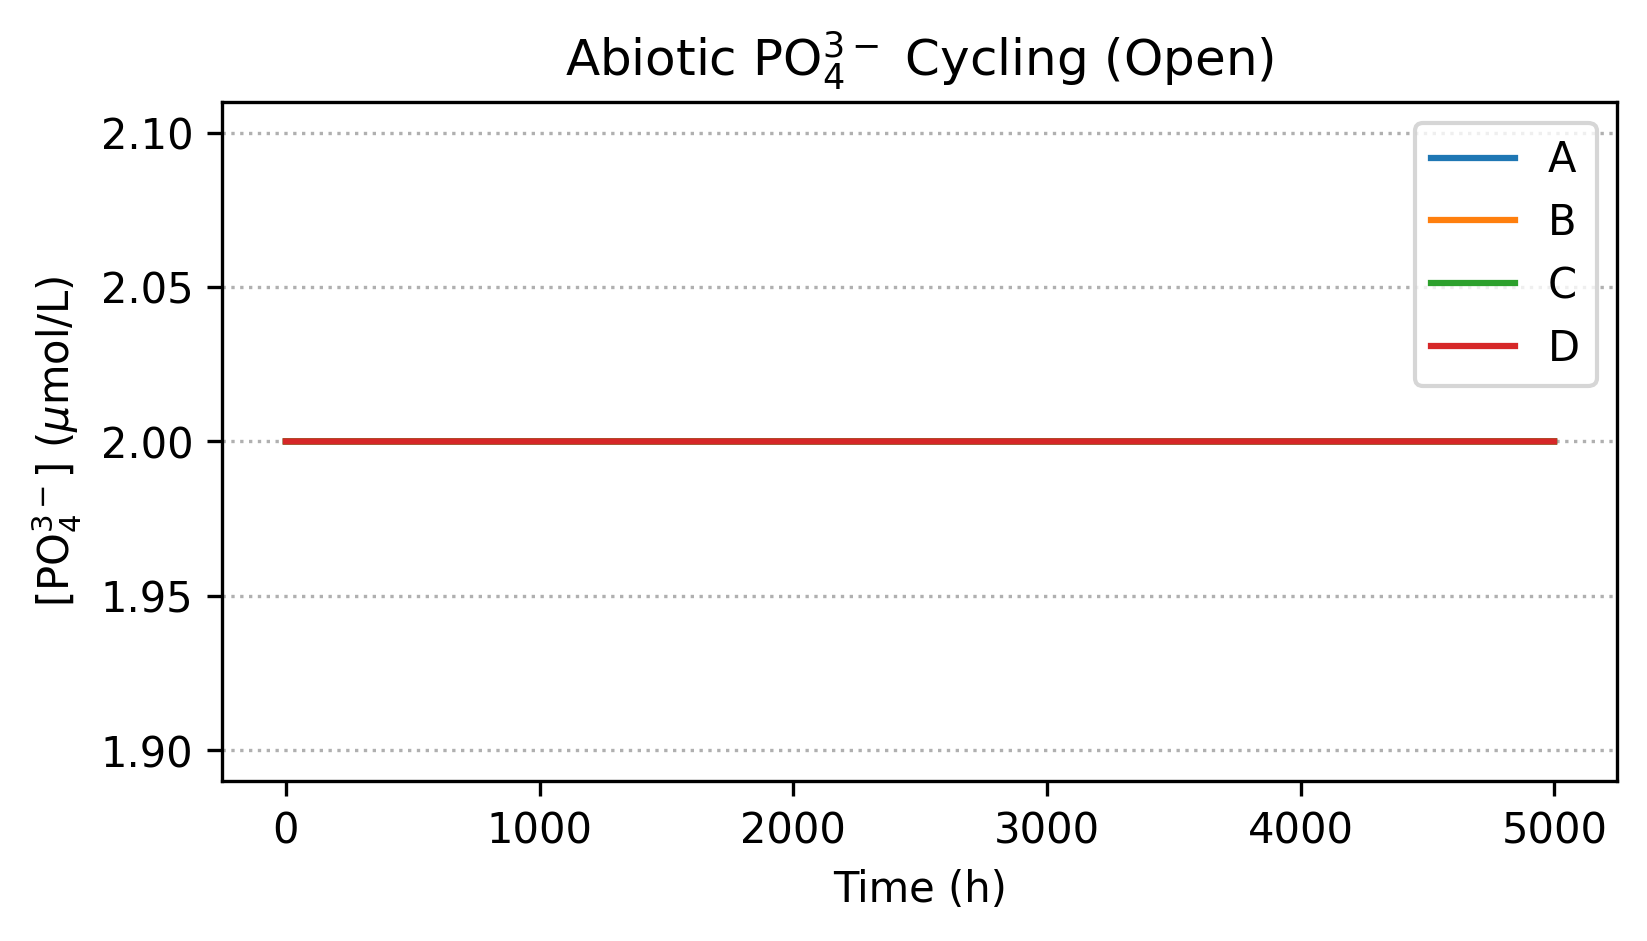

In [111]:
Q_open = np.array([[-8,  2,  0,  5],
                   [8, -12,  4,  0],
                   [0,  10, -12, 2],
                   [0,  0,   8, -8]]) # L/hr

q_ext = np.array([1, 0, 0, 0]) # external volumetric flux (L/hr)
c_ext = 2 # external concentration (umol/L)
e = q_ext*c_ext # external amount flux (umol/hr)

def system_open(c, t):
    return (Q_open @ c + e) / v

solution_open = odeint(system_open, phosphate_0, t)

plt.plot(t, solution_open, label=abcd)
plt.xlabel('Time (h)')
plt.ylabel('[PO$_4^{3-}$] ($\mu$mol/L)')
plt.title('Abiotic PO$_4^{3-}$ Cycling (Open)')
plt.legend()

plt.savefig("original.pdf")
plt.show()

# print(solution_open[-1])